In [1]:
DAYS = 730
AMOUNT = 100000
tickers = ['COROMANDEL.NS', 'NTPC.NS', 'SBIN.NS', 'TCS.NS','COALINDIA.NS','HAL.NS','IRCON.NS']

In [2]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=DAYS)).strftime("%Y-%m-%d")


data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date         Ticker   Adj Close       Close        High  \
0         2022-07-14   COALINDIA.NS  161.306137  192.000000  195.449997   
1         2022-07-14  COROMANDEL.NS  950.922363  969.450012  988.700012   
2         2022-07-14         HAL.NS  839.419617  865.000000  878.500000   
3         2022-07-14       IRCON.NS   34.809093   37.150002   37.549999   
4         2022-07-14        NTPC.NS  137.169937  148.300003  149.300003   

Attribute         Low        Open     Volume  
0          190.300003  194.000000  6795141.0  
1          965.799988  978.700012   242755.0  
2          862.049988  862.375000  1251144.0  
3           37.000000   37.500000   251524.0  
4          147.000000  149.000000  9775869.0  


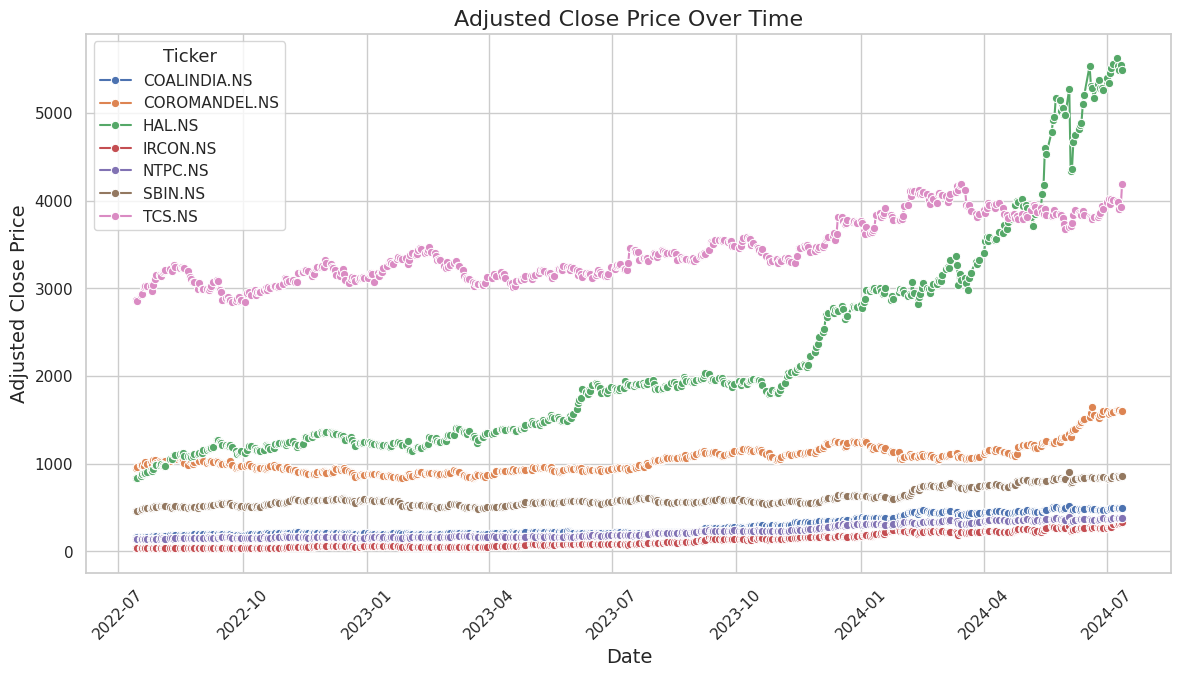

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

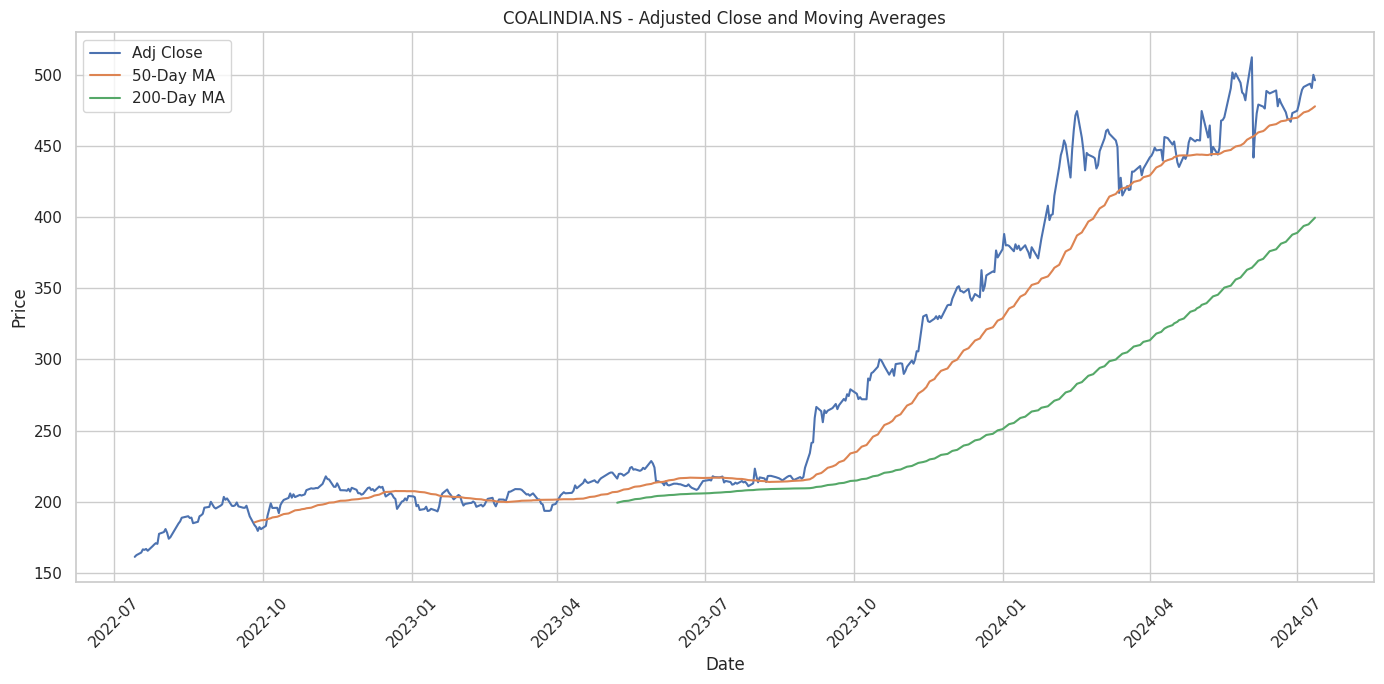

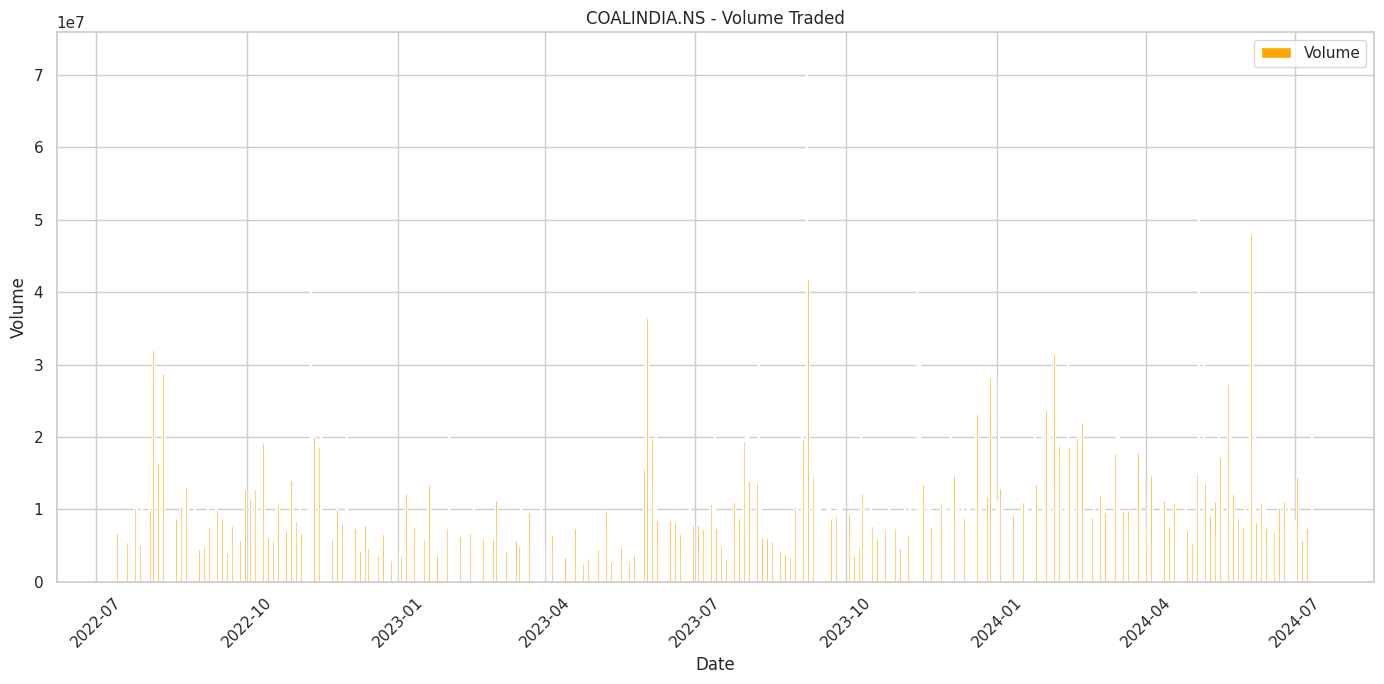

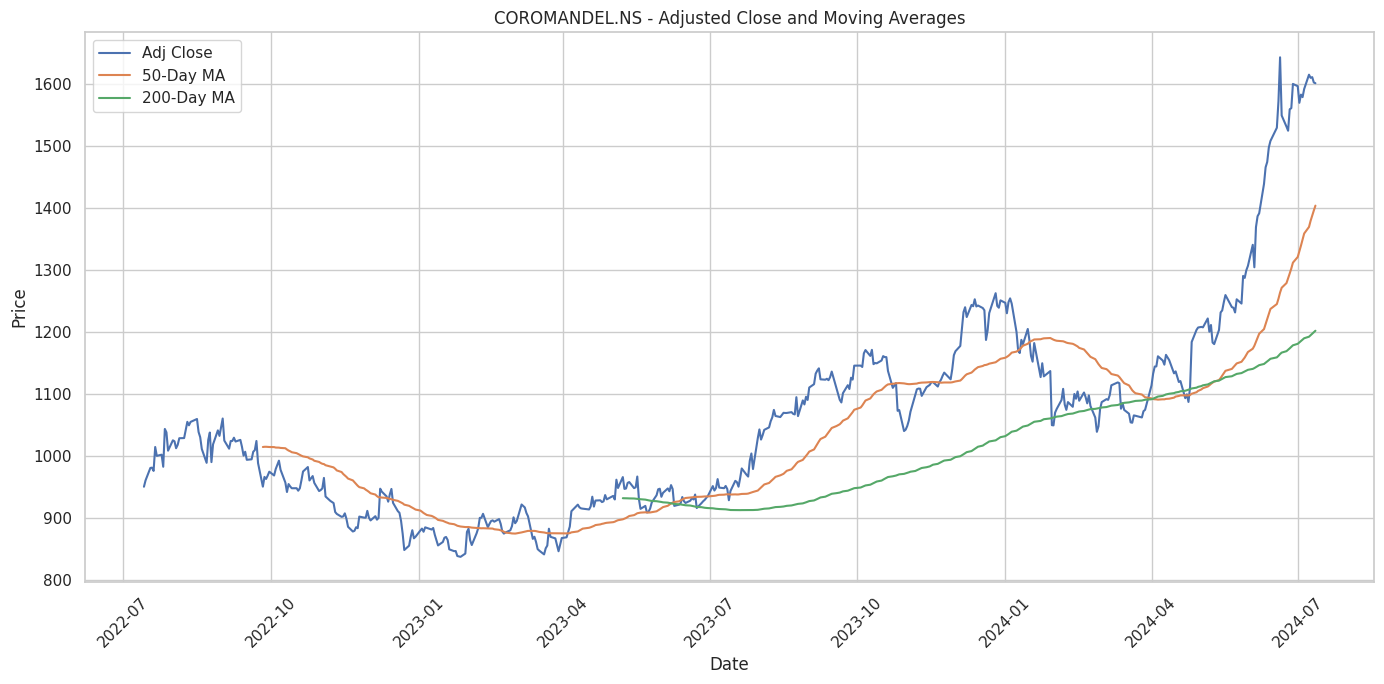

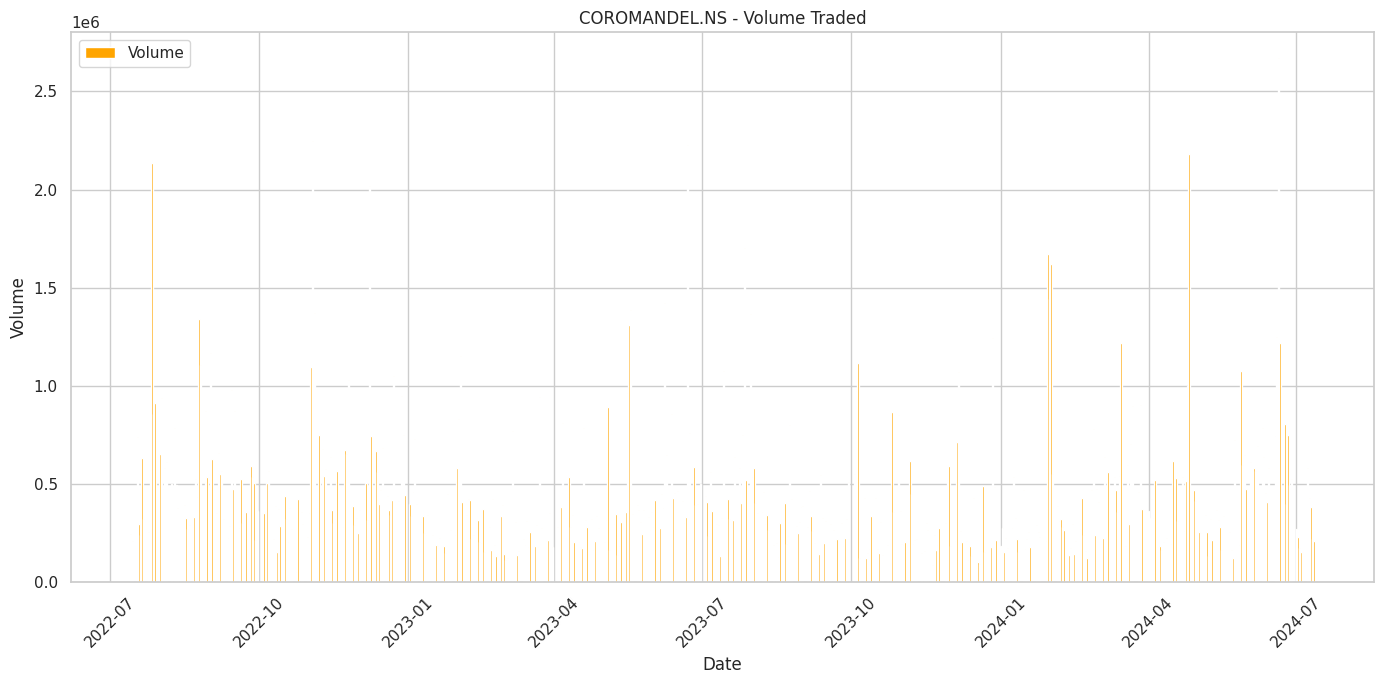

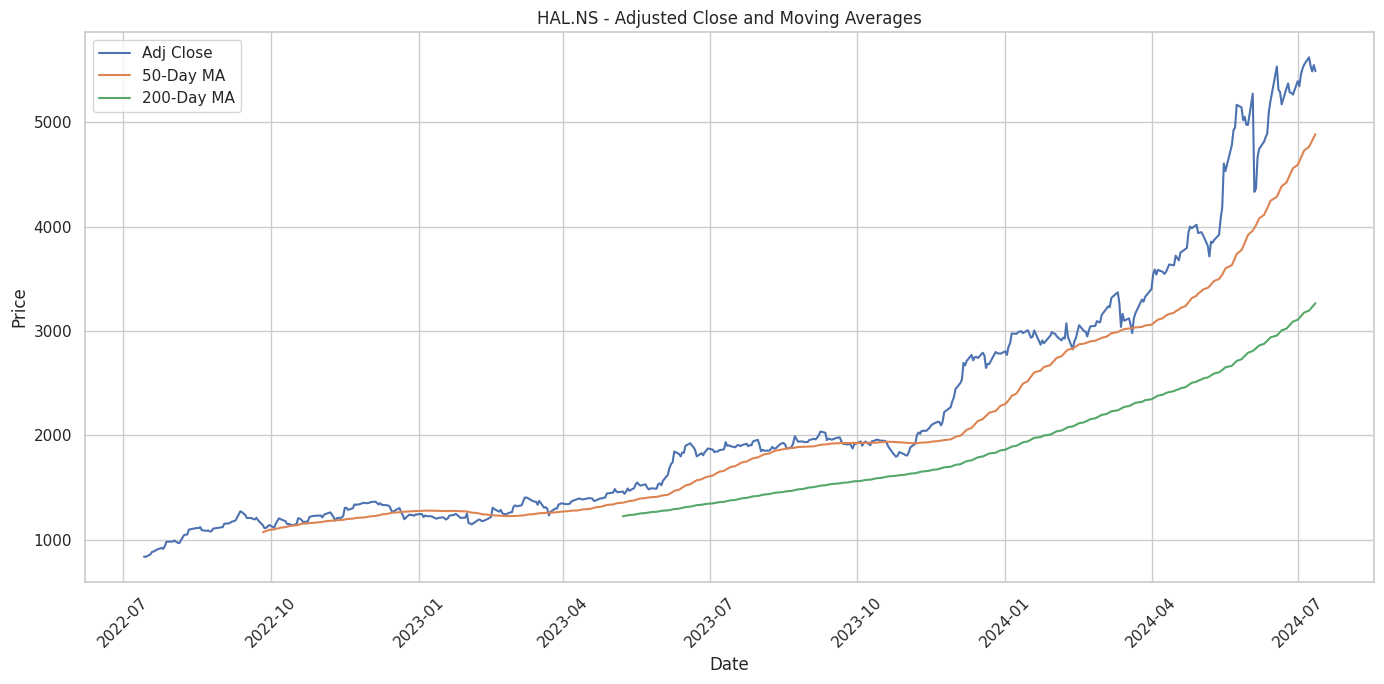

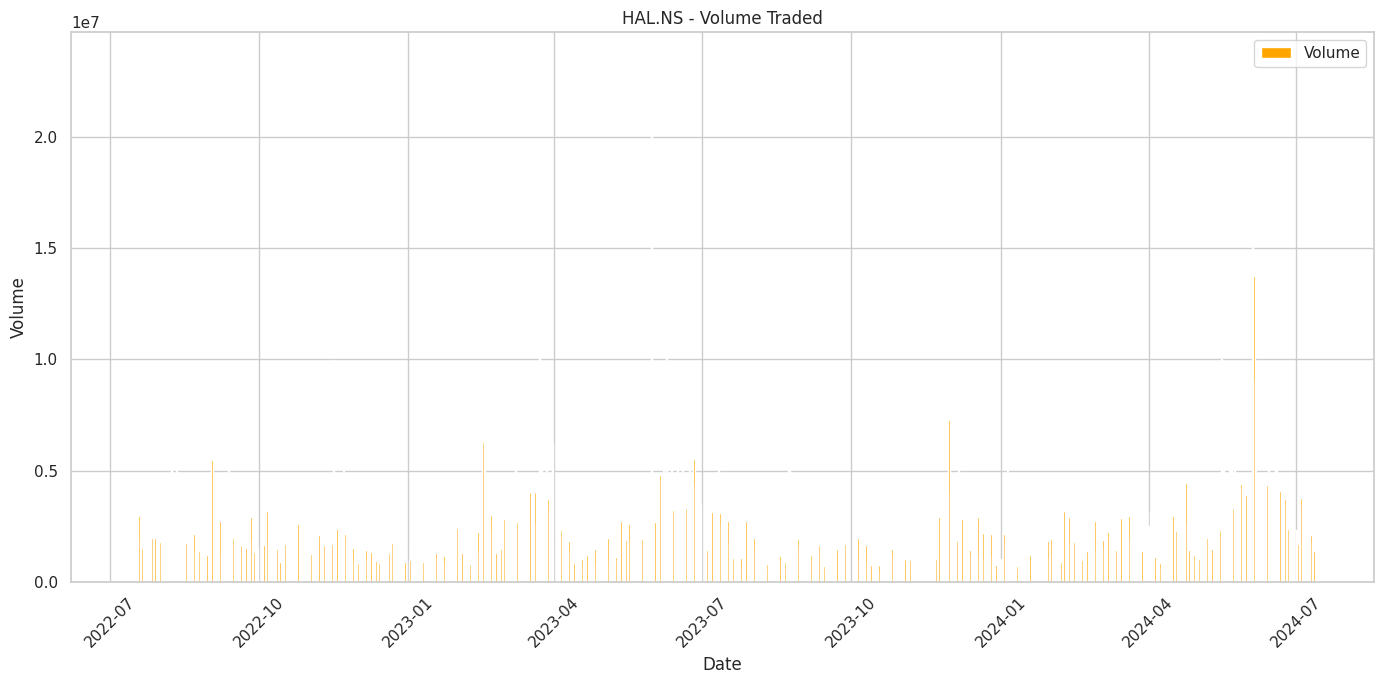

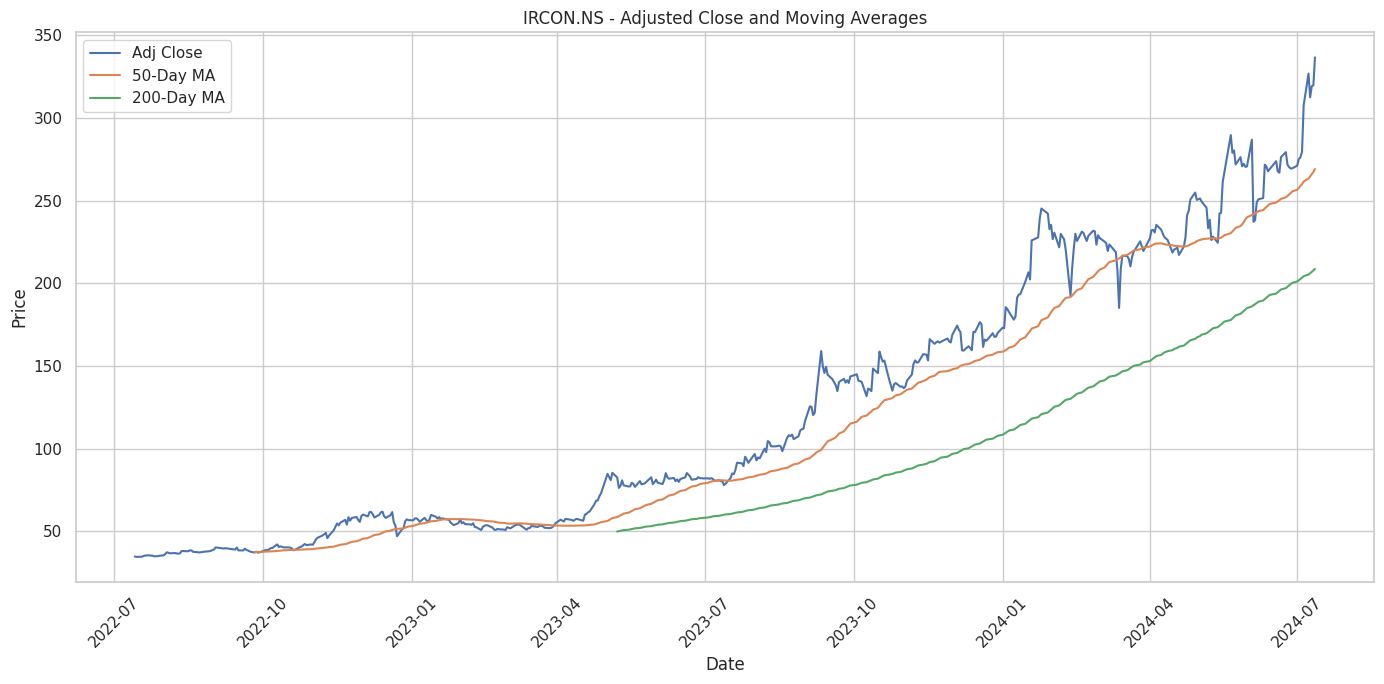

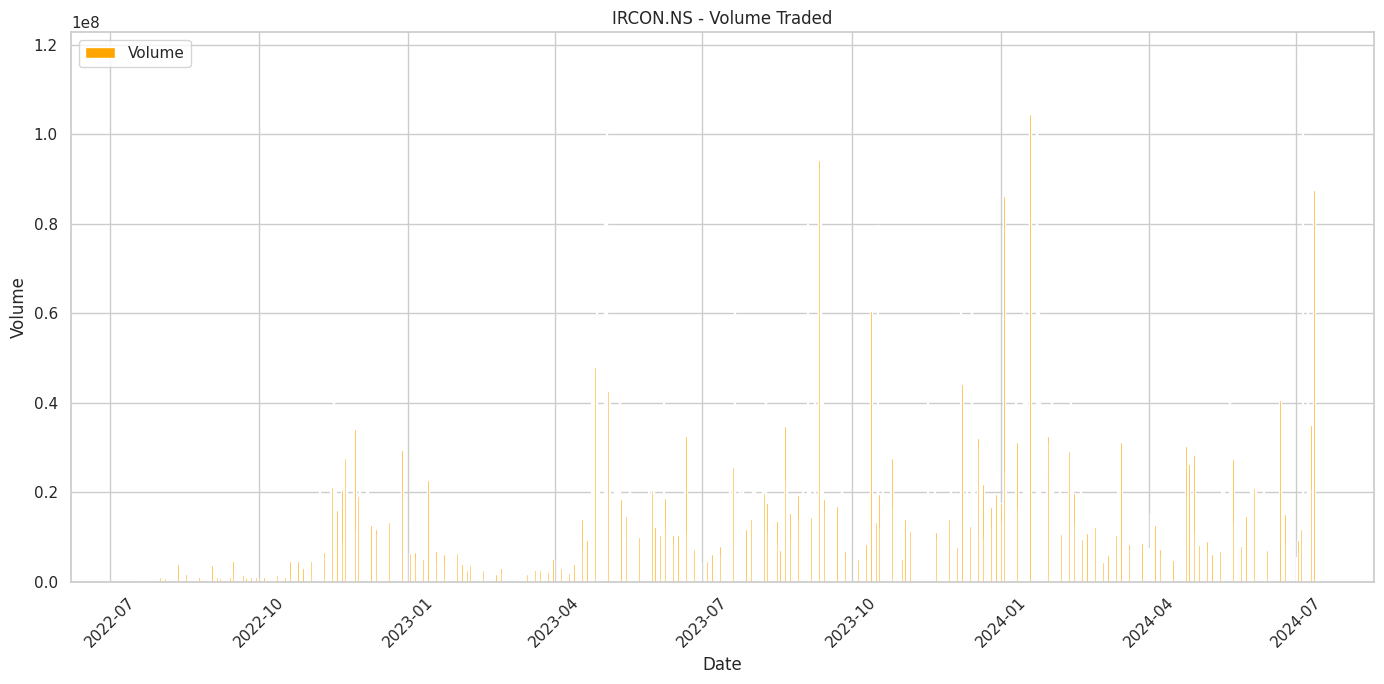

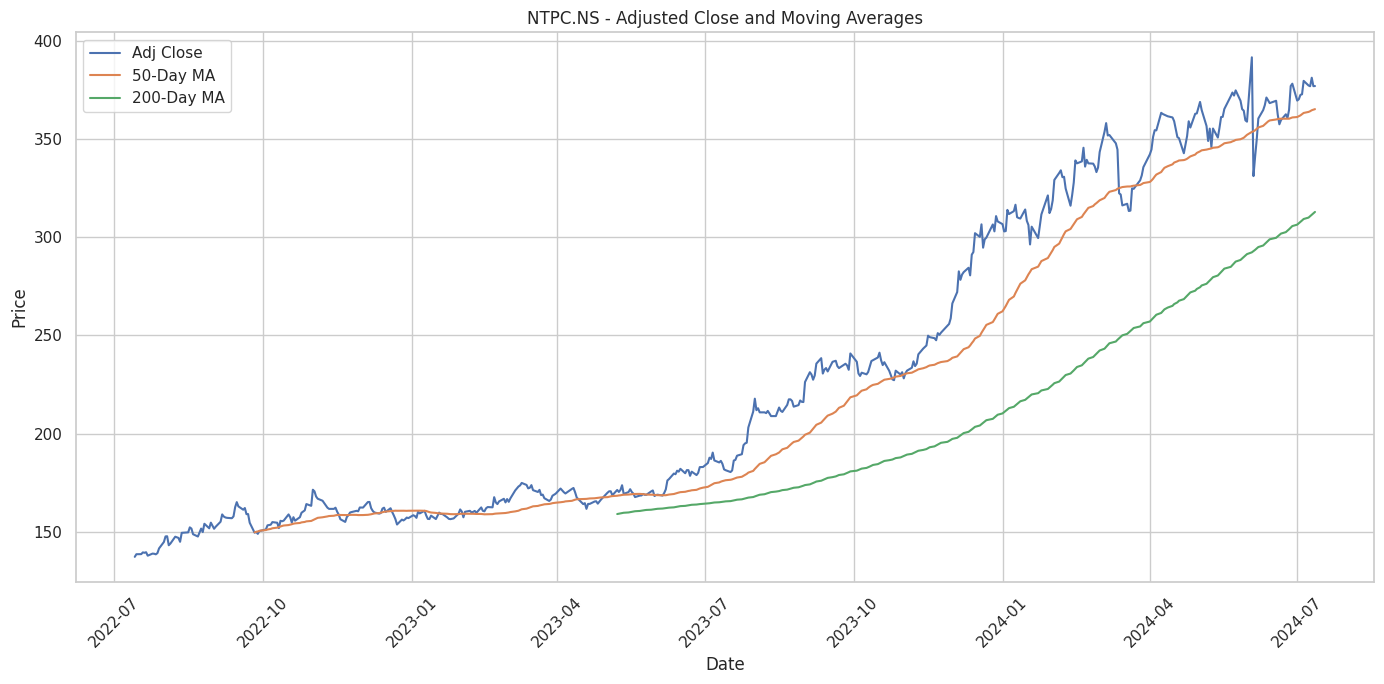

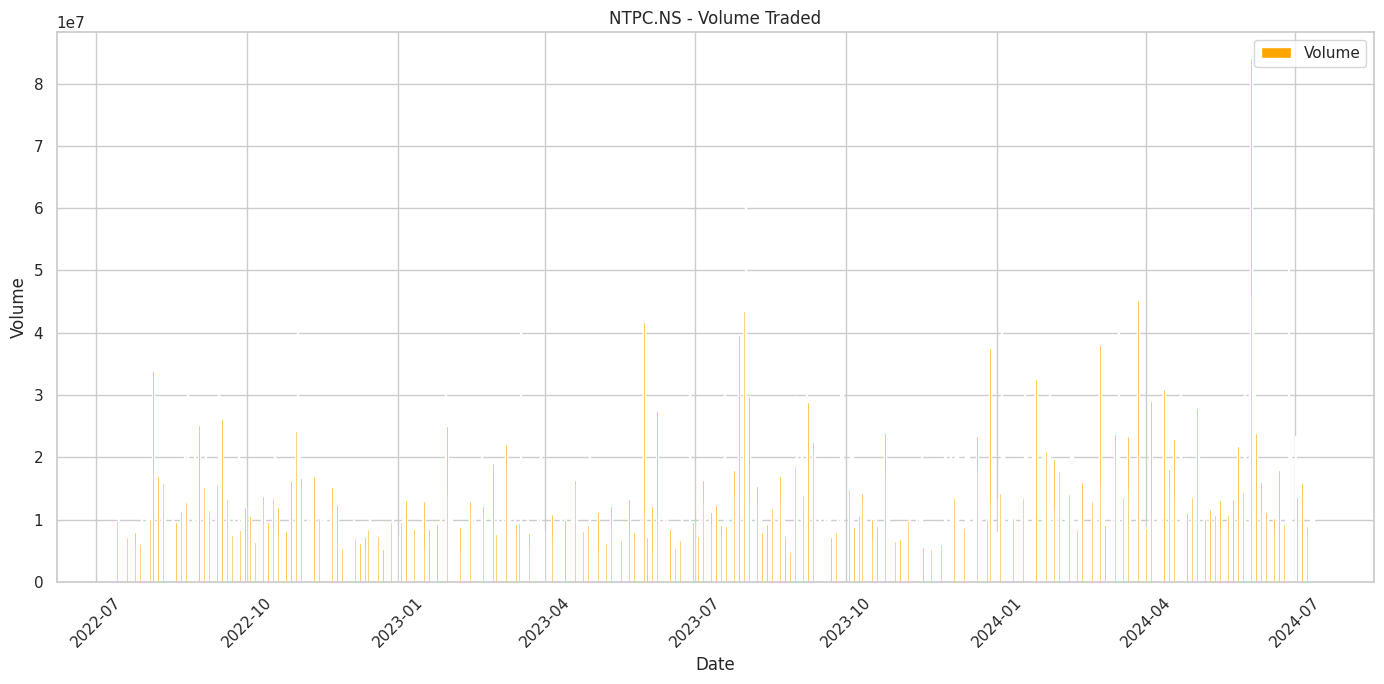

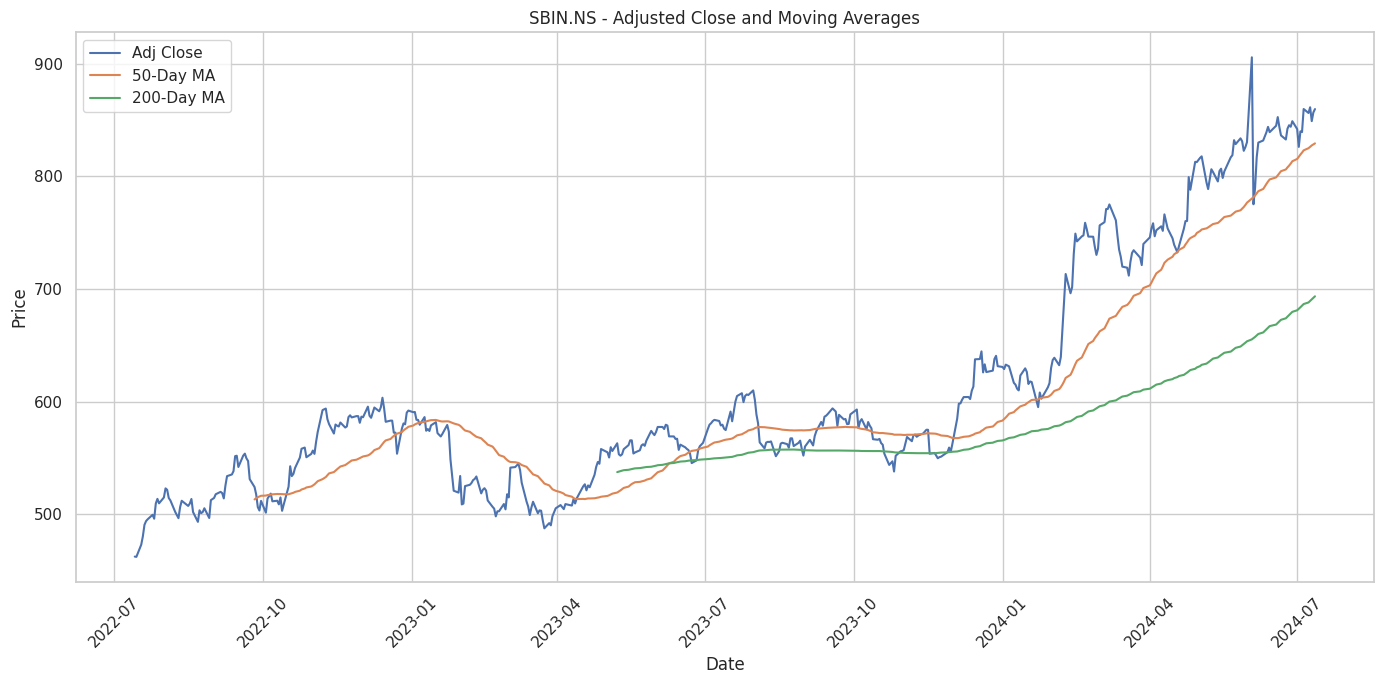

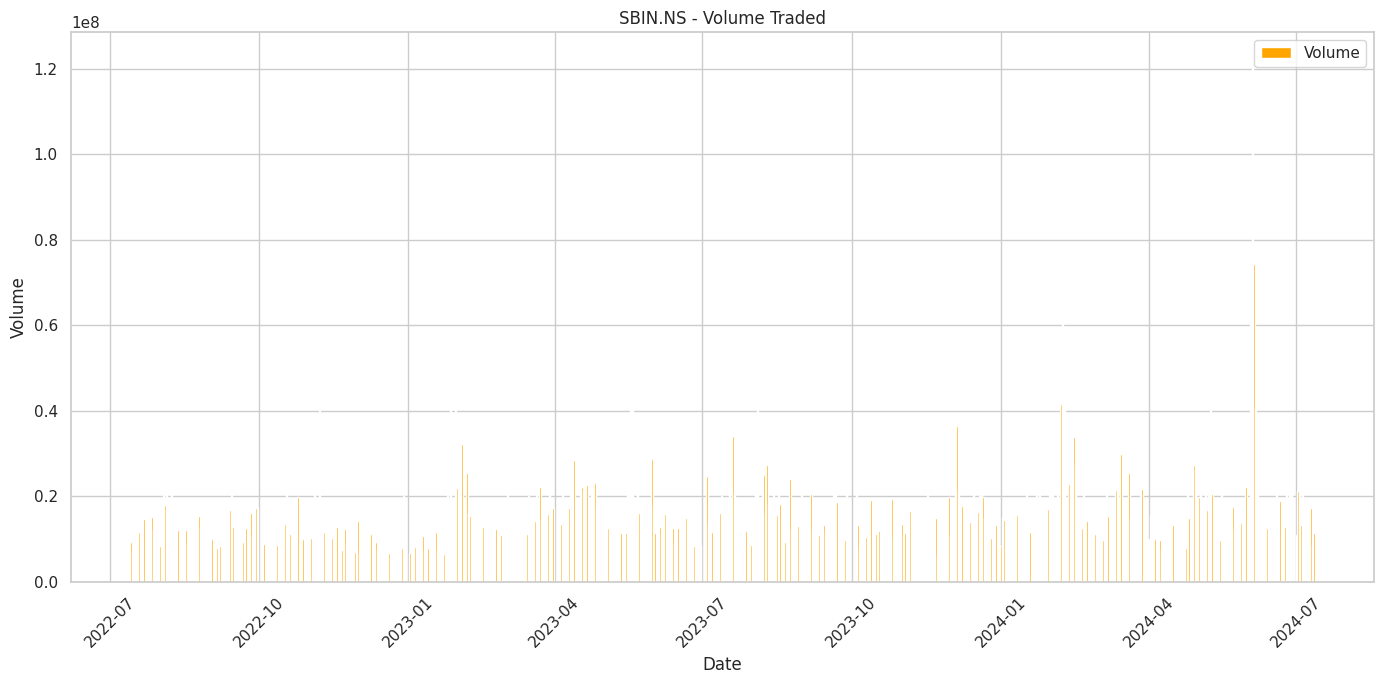

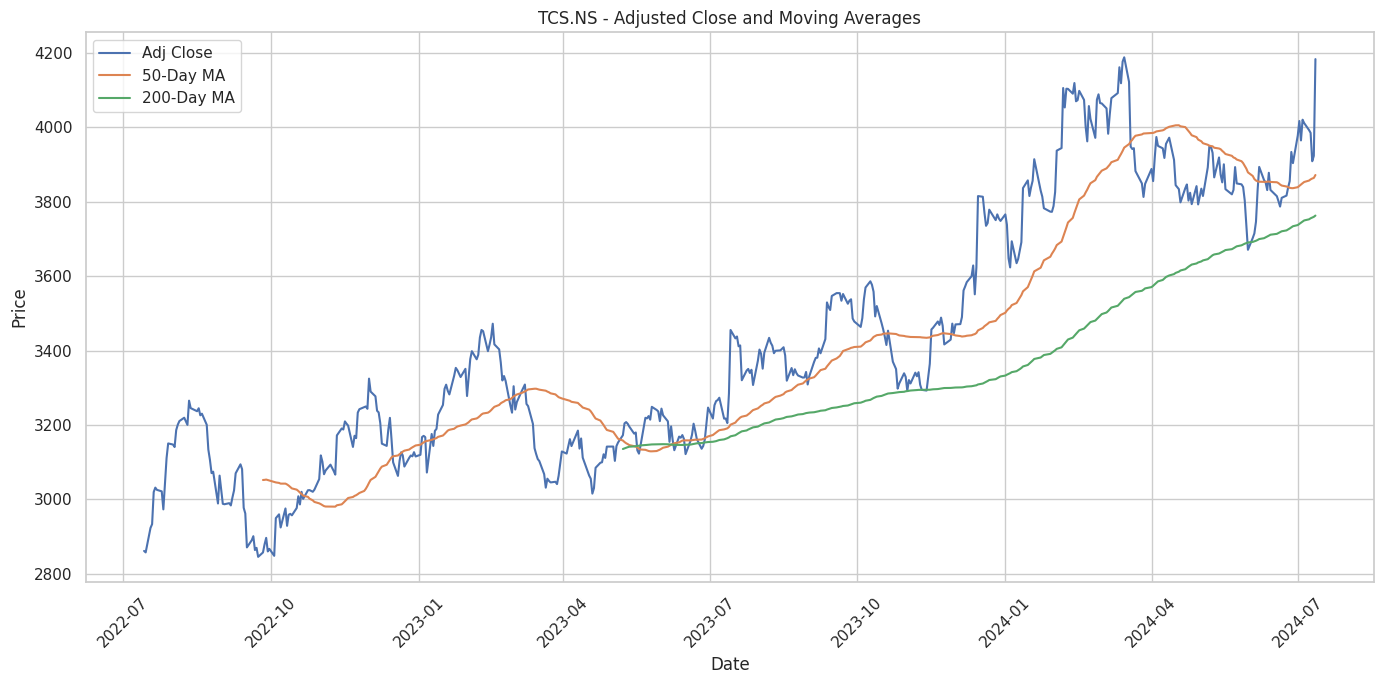

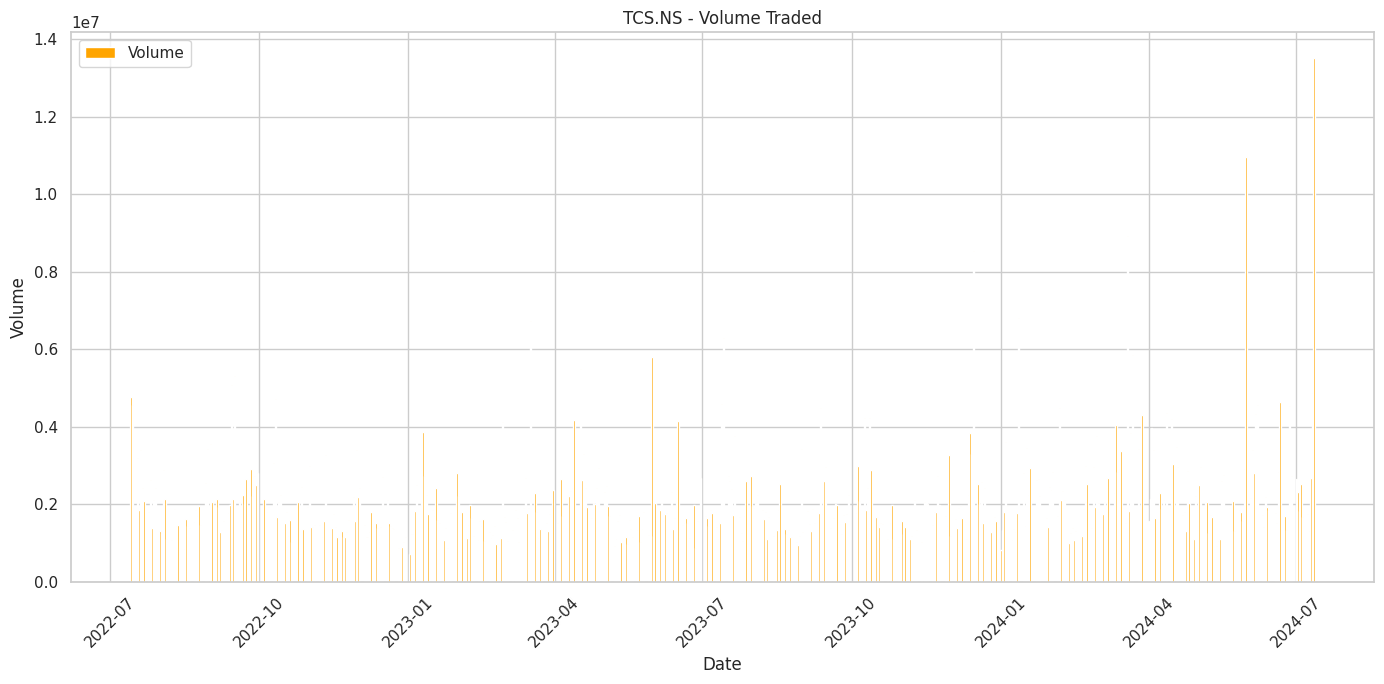

In [4]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Distribution of daily returns of stock for better understanding the constant gains or losses with no more volatility

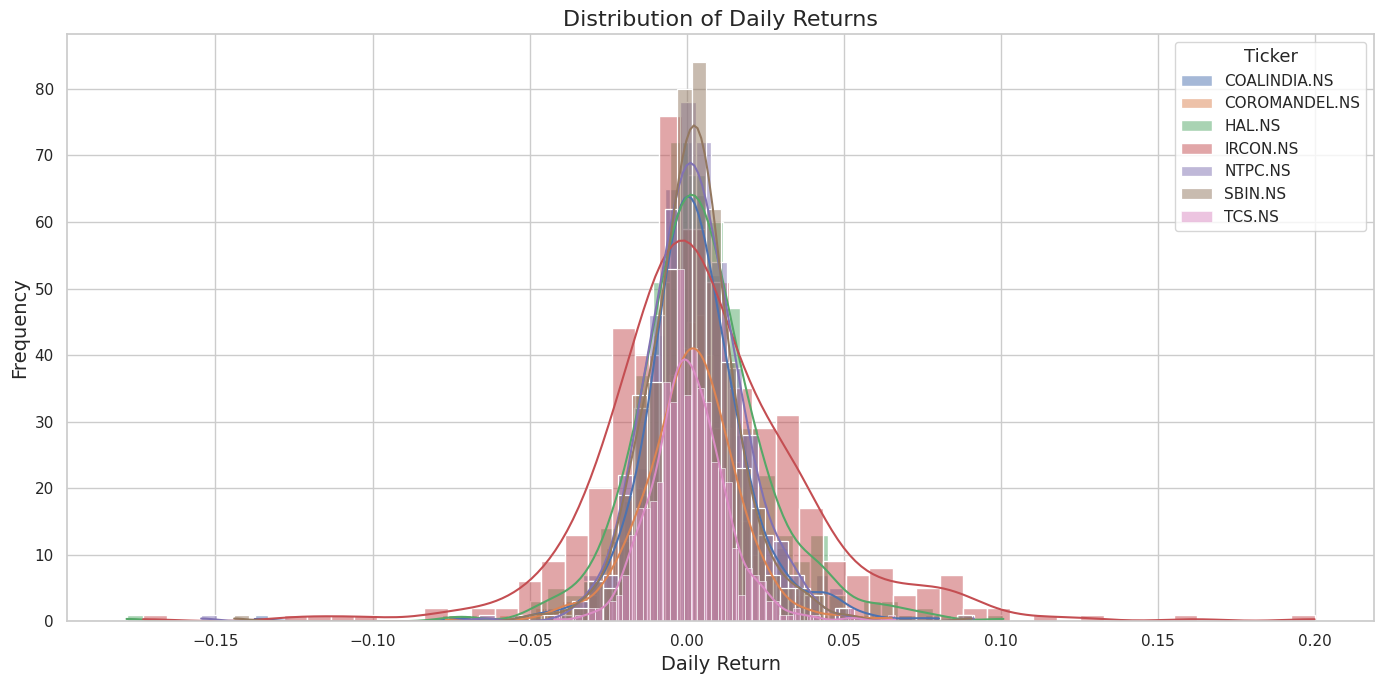

In [5]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

Corelation b/w stocks

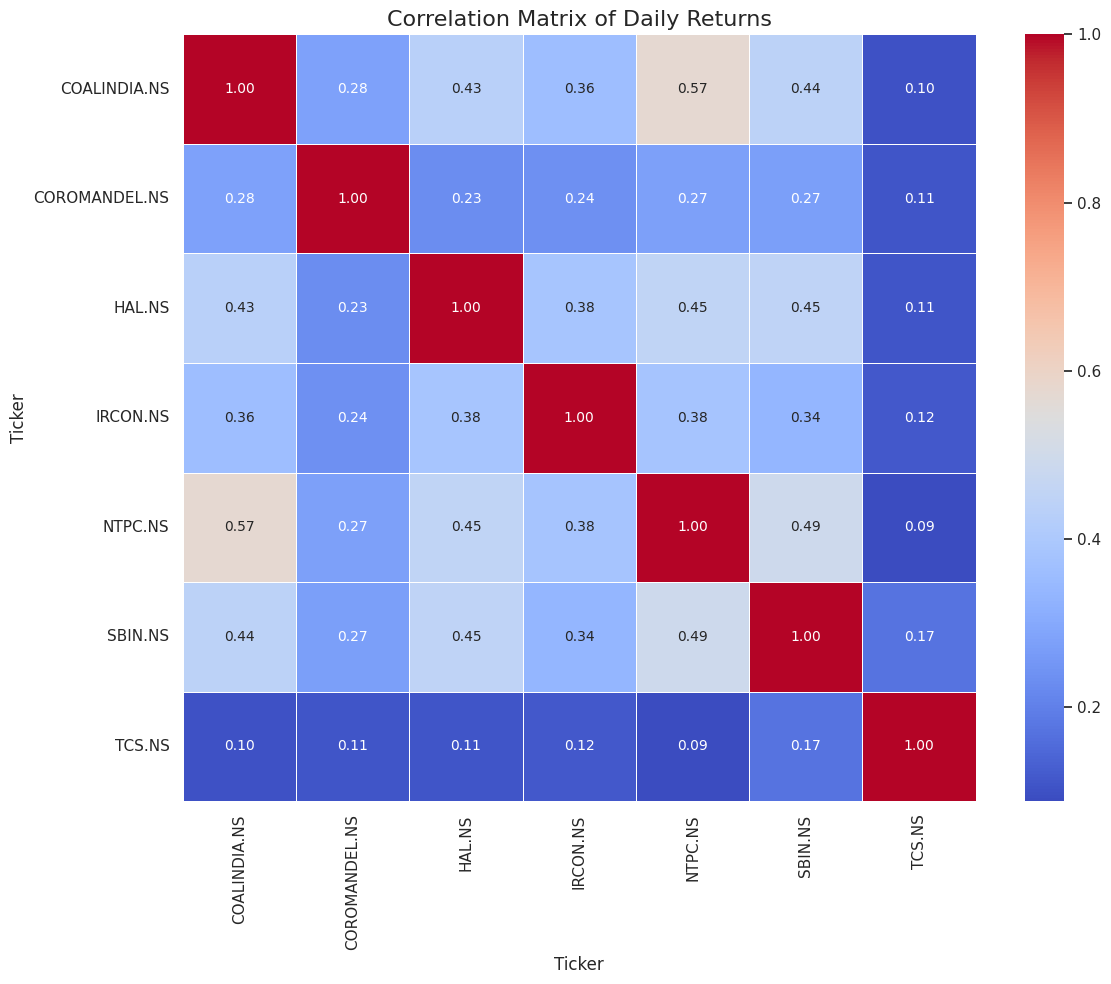

In [6]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:

Calculate the expected returns and volatility for each stock.
Generate a series of random portfolios to identify the efficient frontier.
Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.

In [7]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns*100,
    'Volatility': volatility*100
})

stock_stats

,Expected Return,Volatility
Ticker,,
COALINDIA.NS,61.825501,28.115235
COROMANDEL.NS,30.053124,25.373614
HAL.NS,102.995780,35.186635
IRCON.NS,131.793973,54.740864
NTPC.NS,55.569184,26.274648
SBIN.NS,35.139658,25.286244
TCS.NS,21.477112,19.667782


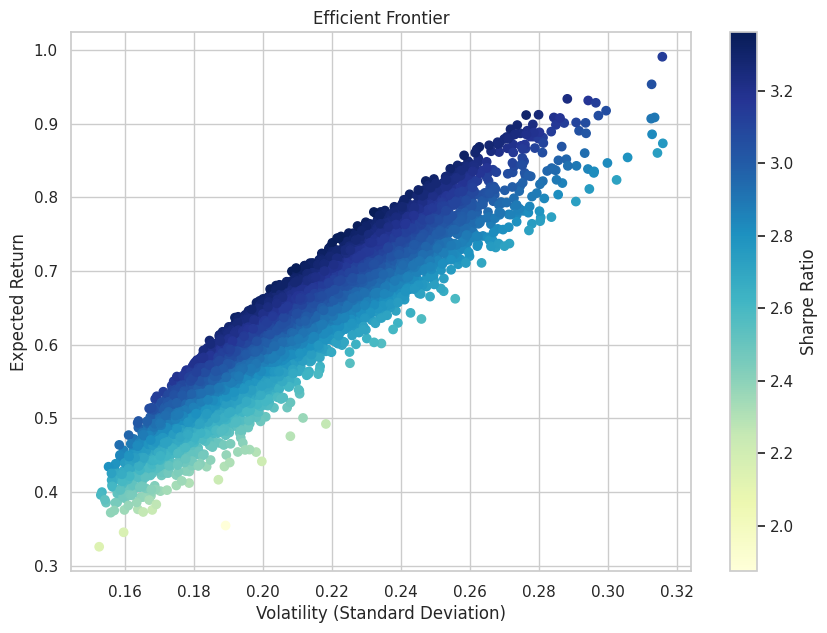

In [8]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

Each dot represents a portfolio, with the colour indicating the Sharpe ratio, a measure of risk-adjusted return. Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of volatility, which represent optimal portfolios. The gradient shows that portfolios with higher Sharpe ratios (darker blue) provide better risk-adjusted returns.

In [9]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.7445739050198937, 0.2214850086442704, 3.361734997675452)

In [10]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights*100
})

portfolio_weights_df

,Ticker,Weight
0,COALINDIA.NS,11.224816
1,COROMANDEL.NS,39.829230
2,HAL.NS,4.426432
3,IRCON.NS,8.097234
4,NTPC.NS,9.350088
5,SBIN.NS,2.215204
6,TCS.NS,24.856995


In [11]:
data = yf.download(tickers, start=start_date, end=end_date, progress=False)
portfolio_weights_df['cur_price'] = [i for i in data.iloc[-1]['Adj Close']]

In [12]:
Money_to_each = max_sharpe_weights*AMOUNT
portfolio_weights_df['Money_to_each'] = Money_to_each
portfolio_weights_df

,Ticker,Weight,cur_price,Money_to_each
0,COALINDIA.NS,11.224816,496.200012,11224.816254
1,COROMANDEL.NS,39.829230,1602.000000,39829.229976
2,HAL.NS,4.426432,5489.200195,4426.432295
3,IRCON.NS,8.097234,336.799988,8097.234196
4,NTPC.NS,9.350088,377.149994,9350.087597
5,SBIN.NS,2.215204,859.700012,2215.204314
6,TCS.NS,24.856995,4183.950195,24856.995368


In [13]:
portfolio_weights_df['no_of_stocks'] = (portfolio_weights_df['Money_to_each']//portfolio_weights_df['cur_price'])
portfolio_weights_df

,Ticker,Weight,cur_price,Money_to_each,no_of_stocks
0,COALINDIA.NS,11.224816,496.200012,11224.816254,22.0
1,COROMANDEL.NS,39.829230,1602.000000,39829.229976,24.0
2,HAL.NS,4.426432,5489.200195,4426.432295,0.0
3,IRCON.NS,8.097234,336.799988,8097.234196,24.0
4,NTPC.NS,9.350088,377.149994,9350.087597,24.0
5,SBIN.NS,2.215204,859.700012,2215.204314,2.0
6,TCS.NS,24.856995,4183.950195,24856.995368,5.0


In [14]:
Total_amount_used = sum(portfolio_weights_df['cur_price']*portfolio_weights_df['no_of_stocks'])
Total_amount_used

89138.35083007812

In [15]:
Amount_unused = AMOUNT - Total_amount_used
Amount_unused

10861.649169921875